In [171]:
from trackml.dataset import load_event
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

import sys
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Añadir la carpeta principal del repo al path
sys.path.append(os.path.abspath(".."))


path = '/nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/'
event = 'event000001000'

print('Loading event {}'.format(path+event))

hits, cells, particles, truth = load_event(path+event)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event, mem_bytes / 2**20))

Loading event /nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/event000001000
event000001000 memory usage 18.46 MB


# Búsqueda de pares prometedores

In [172]:
#============== CONSIDERO SOLO LOS HITS DE LA PARTE CENTRAL DEL DETECTOR ==============#

def distance(particle):
    ''' Distancia en mm de la partícula al origen'''
    return np.sqrt(particle.vx**2 + particle.vy**2 + particle.vz**2)

particles['r'] = distance(particles)
particles['phi'] = np.arctan2(particles.vy, particles.vx)
particles['theta'] = np.arccos(particles.vz / particles.r)

print(particles.head())

# Voy a coger solo las partículas con r < 2.6
particles_all = particles
particles = particles[particles.r < 2.6]

# Con ese radio, voy a coger solo las partículas con z entre -25 y 25 mm
particles = particles[(particles.vz > -25) & (particles.vz < 25)]

# # Histograma normalizado a 1 de la variable r
# plt.figure(figsize=(6, 6))
# plt.hist(particles_all.r, bins=100, range=(0, 100), density=False, alpha=0.5, label='All particles')
# plt.hist(particles.r, bins=100, range=(0, 100), density=False, alpha=0.5, label='Selected particles')
# plt.legend()
# plt.xlabel('r (mm)')    
# plt.ylabel('Number of particles')
# plt.grid(linestyle='--', alpha=0.6)
# plt.show()

# Del truth cojo solo las partículas que están en particles
truth = truth[truth.particle_id.isin(particles.particle_id)]

# Cojo ahora los hits_id que están en truth
hits_all = hits
hits = hits[hits.hit_id.isin(truth.hit_id)]
print(hits.head())

print("Los datos que tomo son un {:.4f}% de los datos originales".format(hits.shape[0]/hits_all.shape[0]*100))

# Unimos los particle_id a hits
hits = hits.merge(truth[['hit_id', 'particle_id']], on='hit_id', how='left')

        particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits         r      phi     theta  
0  -0.203492 -1      8  0.079048  2.32629  2.969372  
1   2.010060  1     11  0.079048  2.32629  2.969372  
2   0.683881 -1      0  0.079048  2.32629  2.969372  
3   0.991616  1     12  0.079048  2.32629  2.969372  
4 -39.824902  1      3  0.079048  2.32629  2.969372  
    hit_id          x         y       z  volume_id  layer_id  module_id
1        2 -55.336102  0.635342 -1502.5          7         2          1
9       10 -90.292900 -3.269370 -1502.5          7         2          1
10      1

In [173]:
print(np.rad2deg(np.arccos(1e-3)))

89.94270421093762


In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from kalman_filter import get_hits_dict


# Selección de volúmenes
volume_ids = hits['volume_id'].unique()
volume_ids = volume_ids[[1, 4, 7]]  
first_volume = volume_ids[0]

hits_dict = get_hits_dict(hits, volume_ids, OCTANTE=True)

# Capas
first_layer = sorted(hits_dict[first_volume].keys())[0]
second_layer = sorted(hits_dict[first_volume].keys())[1]
third_layer = sorted(hits_dict[first_volume].keys())[2]

layer1 = hits_dict[first_volume][first_layer]
layer2 = hits_dict[first_volume][second_layer]
layer3 = hits_dict[first_volume][third_layer]

# Coordenadas y IDs
coords1 = layer1[['x', 'y', 'z']].values
coords2 = layer2[['x', 'y', 'z']].values
coords3 = layer3[['x', 'y', 'z']].values

print(layer1.head())

ids1 = layer1['particle_id'].values
ids2 = layer2['particle_id'].values
ids3 = layer3['particle_id'].values

# Umbral de ángulo
cone_angle = np.deg2rad(1)  

def angle(v1, v2):
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos_theta, -1.0, 1.0))

triplets = []
labels = []


print("Generando triplets...")
print(f'Ángulo de cono: {np.rad2deg(cone_angle):.2f} grados')
''' En vez de unir todos los hits lo que hago es unir solo los que estén entre un ángulo determinado.'''
for i, v1 in enumerate(tqdm(coords1, desc="Layer 1")):
    id1 = ids1[i]
    for j, v2 in enumerate(coords2):
        id2 = ids2[j]
        a12 = angle(v1, v2)
        if a12 < cone_angle:
            for k, v3 in enumerate(coords3):
                id3 = ids3[k]
                a23 = angle(v2, v3)
                if a23 < cone_angle:
                    triplet = np.stack([v1, v2, v3])  # (3,3)
                    label = int(id1 == id2 == id3)
                    triplets.append(triplet)
                    labels.append(label)

triplets = np.array(triplets)  # Shape (N, 3, 3)
labels = np.array(labels)

# Balanceo de positivos y negativos
positive_idx = np.where(labels == 1)[0]
negative_idx = np.where(labels == 0)[0]

n_pos = len(positive_idx)
n_neg = len(negative_idx)

BALANCEO = False
if BALANCEO:
    if n_pos > 0 and n_neg >= n_pos:
        negative_sample = resample(negative_idx, replace=False, n_samples=n_pos, random_state=42)
        selected_idx = np.concatenate([positive_idx, negative_sample])
        X = triplets[selected_idx]
        y = labels[selected_idx]
    elif n_pos > 0 and n_neg < n_pos:
        print(f"No hay suficientes negativos. Usando todos los {n_neg} negativos.")
        selected_idx = np.concatenate([positive_idx[:n_neg], negative_idx])
        X = triplets[selected_idx]
        y = labels[selected_idx]
    else:
        print("No hay triplets positivos. Revisa el ángulo o capas seleccionadas.")
        X = np.array([])
        y = np.array([])
    print(f"Total triplets: {len(X)}")
    print(f"Antes del balanceo:\n Positivos: {np.sum(labels == 1)}, Negativos: {np.sum(labels == 0)}")
    num_pos = np.sum(y == 1)
    num_neg = np.sum(y == 0)
    print(f"Después del balanceo:\n Positivos: {num_pos}, Negativos: {num_neg}")

else:
    print("No se realiza balanceo.")
    X = triplets
    y = labels
    print(f"Total triplets: {len(X)}")
    print(f"Positivos: {np.sum(y == 1)}, Negativos: {np.sum(y == 0)}")
        

# Normalización de las coordenadas para convergencia del modelo
from sklearn.preprocessing import StandardScaler
X_scaled = X.reshape(X.shape[0], -1)  # Aplanar las coordenadas (N, 9)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scaled)  # Normalización de las coordenadas


      hit_id          x          y           z  volume_id  layer_id  \
8907   25632  23.833300  20.511999  302.970001          8         2   
7712   22612  21.475100  23.152201   37.627602          8         2   
7819   22860  10.069700  30.921301    6.063140          8         2   
7664   22464  32.632999   1.923700   60.723099          8         2   
8647   24936   7.712100  31.054300  189.369003          8         2   

      module_id         particle_id           r  
8907        186  459369292295569408  304.597412  
7712        122  346777240027004928   49.122711  
7819        124  274720058305937408   33.080013  
7664        121  828664461739950080   68.963089  
8647        156  684556283050721280  192.053299  
Generando triplets...
Ángulo de cono: 1.00 grados


Layer 1: 100%|██████████| 430/430 [00:03<00:00, 114.55it/s]

No se realiza balanceo.
Total triplets: 431
Positivos: 180, Negativos: 251


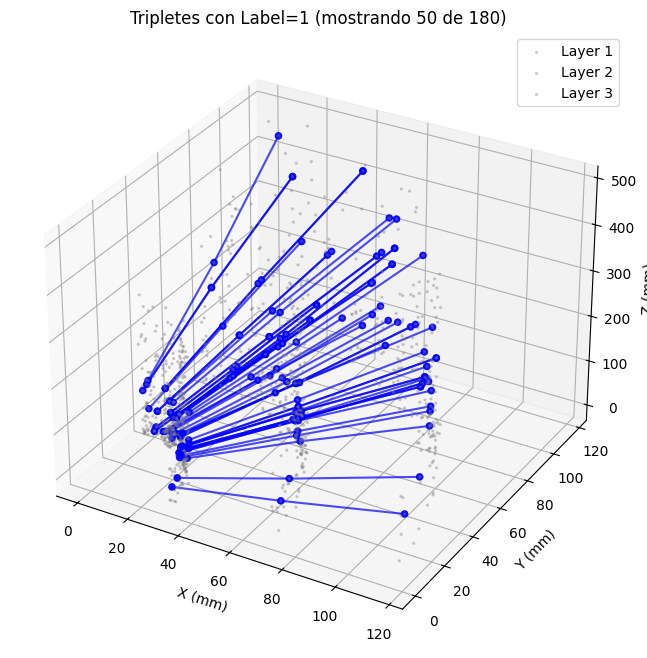

In [175]:
def plot_all_positive_triplets(triplets, labels, layer1, layer2, layer3):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Graficar todos los hits de las 3 capas en gris con baja opacidad
    ax.scatter(layer1.x, layer1.y, layer1.z, c='gray', s=2, alpha=0.3, label='Layer 1')
    ax.scatter(layer2.x, layer2.y, layer2.z, c='gray', s=2, alpha=0.3, label='Layer 2')
    ax.scatter(layer3.x, layer3.y, layer3.z, c='gray', s=2, alpha=0.3, label='Layer 3')

    # Filtrar solo tripletes con label 1 (positivos)
    pos_idx = np.where(labels == 1)[0]

    # Para no saturar el plot, limita a máximo N tripletes
    N = 50  
    count = 0

    for idx in pos_idx:
        triplet = triplets[idx].reshape(3, 3)  # (3 hits, xyz)
        # Conectar los 3 puntos con línea
        ax.plot(triplet[:, 0], triplet[:, 1], triplet[:, 2], color='blue', alpha=0.7)
        # Poner los puntos del triplete
        ax.scatter(triplet[:, 0], triplet[:, 1], triplet[:, 2], c='blue', s=20, alpha=0.9)
        count += 1
        if count >= N:
            break

    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_title(f'Tripletes con Label=1 (mostrando {count} de {len(pos_idx)})')
    ax.legend()
    plt.show()

# Llamada para mostrar
plot_all_positive_triplets(X, labels, layer1, layer2, layer3)


In [176]:
import os
import time
import numpy as np
from tqdm import tqdm
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Dataset personalizado
class TripletDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataset y dataloaders
def create_dataloaders(X, y, batch_size, seed=42):
    dataset = TripletDataset(X, y)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    # Establece la semilla para reproducibilidad
    generator = torch.Generator().manual_seed(seed)
    
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print("Dataset original length:", len(dataset))
    print("Train subset length:", len(train_dataset))
    print("Val subset length:", len(val_dataset))

    return train_loader, val_loader


# print("Tamaño del dataset de entrenamiento:", len(train_loader.dataset))
# print("Tamaño del dataset de validación:", len(val_loader.dataset))

In [177]:
from model import TripletNet, SimpleNet
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
X = X_scaled

# Parámetros adicionales
batch_size = 16
lr = 1e-3
epochs = 30

# Cargamos el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNet().to(device)
criterion = nn.BCEWithLogitsLoss()

if BALANCEO == False:
    pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=lr)

# Directorio de salida y log
out_dir = './output'
os.makedirs(out_dir + '/checkpoint', exist_ok=True)

log = open(out_dir + '/log.train.txt', 'w')
log.write(f'** start training at {str(datetime.now())} **\n')

# Cargamos los datos
train_loader, val_loader = create_dataloaders(X, y, batch_size=batch_size)

iter_accum = 1
iter_valid = len(train_loader)

def evaluate(model, loader):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            total += y.size(0)
    return val_loss / total, val_correct / total

def evaluate_metrics(model, loader):
    model.eval()
    y_true_all = []
    y_pred_logits_all = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            y_true_all.append(y)
            y_pred_logits_all.append(logits)

    y_true = torch.cat(y_true_all)
    y_pred_logits = torch.cat(y_pred_logits_all)
    y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float()

    print("\nConfusion Matrix (Validation Set):")
    print(confusion_matrix(y_true.cpu(), y_pred.cpu()))
    print("\nClassification Report (Validation Set):")
    print(classification_report(y_true.cpu(), y_pred.cpu(), digits=4))


# Training loop 
train_loss, valid_loss = 0, 0
j = 0  # steps
i = 0  # iteraciones acumuladas

train_losses, valid_losses, train_accs, valid_accs = [], [], [], []

model.train()
start = time.time()


log.write(' iter   |  valid_loss  valid_acc |  train_loss  train_acc | time\n')
log.write('---------------------------------------------------------------\n')

for epoch in range(epochs):
    sum_loss = 0.0
    correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()

        if j % iter_accum == 0:
            optimizer.step()

        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
        sum_loss += loss.item() * x.size(0)

        if j % iter_valid == 0 and j > 0:
            v_loss, v_acc = evaluate(model, val_loader)
            train_loss = sum_loss / total
            train_acc = correct / total
            t = time.strftime("%H:%M:%S", time.gmtime(time.time() - start))

            log.write(f'{j:6d} |  {v_loss:.4f}     {v_acc:.4f} |  {train_loss:.4f}     {train_acc:.4f} | {t}\n')
            log.flush()

            torch.save(model.state_dict(), f'{out_dir}/checkpoint/{j:08d}_model.pth')
            torch.save({'optimizer': optimizer.state_dict()}, f'{out_dir}/checkpoint/{j:08d}_optimizer.pth')

            sum_loss = 0.0
            correct = 0
            total = 0

        j += 1

    # Al final del epoch calculamos métricas finales (entrenamiento y validación)
    train_loss = sum_loss / total if total > 0 else 0
    train_acc = correct / total if total > 0 else 0
    v_loss, v_acc = evaluate(model, val_loader)

    print(f'Epoch {epoch+1}/{epochs} completed.')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Validation Loss: {v_loss:.4f}, Validation Acc: {v_acc:.4f}')
    print(f'Time elapsed: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')
    train_losses.append(train_loss)
    valid_losses.append(v_loss)
    train_accs.append(train_acc)
    valid_accs.append(v_acc)

# print(f'\nEvaluation metrics...\n{evaluate_metrics(model, val_loader)}')

import io
import contextlib

# Guardado final
torch.save(model.state_dict(), f'{out_dir}/checkpoint/final_model.pth')
log.write('\n** Finished Training **\n')

# Capturar las métricas impresas
f = io.StringIO()
with contextlib.redirect_stdout(f):
    evaluate_metrics(model, val_loader)

log.write('\nEvaluation metrics:\n')
log.write(f.getvalue())
log.close()


Dataset original length: 431
Train subset length: 387
Val subset length: 44
Epoch 1/30 completed.
Train Loss: 0.6756, Train Acc: 0.6357
Validation Loss: 0.6236, Validation Acc: 0.7500
Time elapsed: 00:00:00
Epoch 2/30 completed.
Train Loss: 0.6384, Train Acc: 0.6712
Validation Loss: 0.5672, Validation Acc: 0.7273
Time elapsed: 00:00:00
Epoch 3/30 completed.
Train Loss: 0.6146, Train Acc: 0.6712
Validation Loss: 0.5243, Validation Acc: 0.7727
Time elapsed: 00:00:00
Epoch 4/30 completed.
Train Loss: 0.6045, Train Acc: 0.6873
Validation Loss: 0.5132, Validation Acc: 0.7727
Time elapsed: 00:00:00
Epoch 5/30 completed.
Train Loss: 0.5864, Train Acc: 0.6981
Validation Loss: 0.5109, Validation Acc: 0.7727
Time elapsed: 00:00:00
Epoch 6/30 completed.
Train Loss: 0.5903, Train Acc: 0.6900
Validation Loss: 0.5108, Validation Acc: 0.7500
Time elapsed: 00:00:00
Epoch 7/30 completed.
Train Loss: 0.5866, Train Acc: 0.6981
Validation Loss: 0.5116, Validation Acc: 0.7727
Time elapsed: 00:00:00
Epoch 8

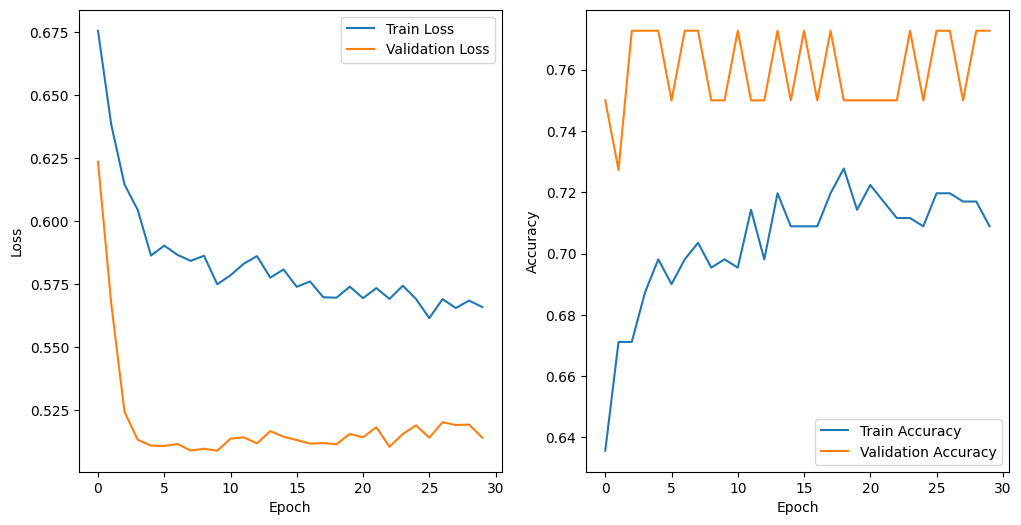

In [178]:
%matplotlib inline
# Graficar las pérdidas y precisiones
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(valid_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

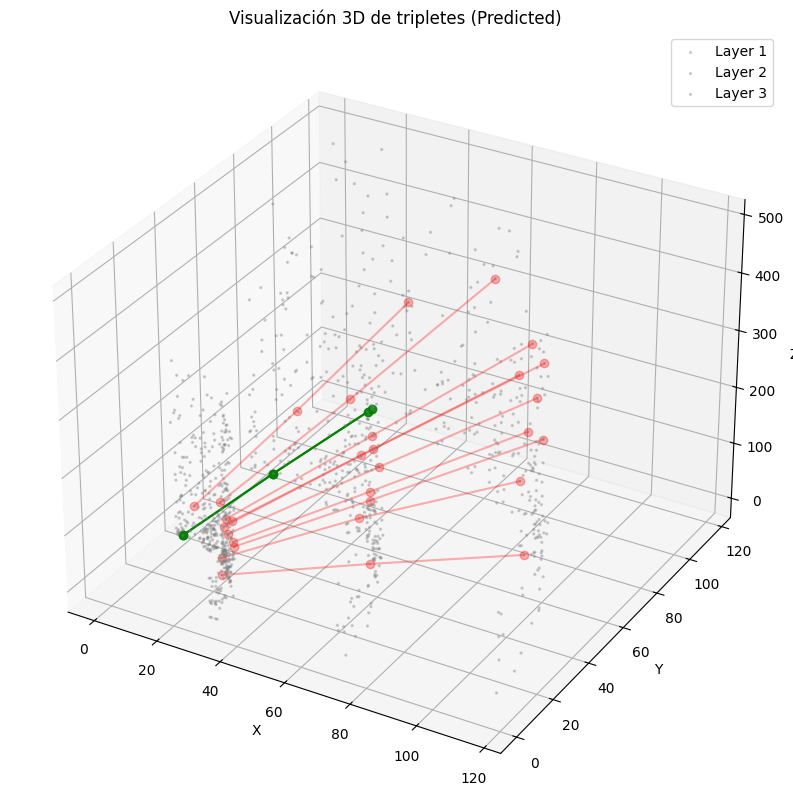

In [179]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Volver a forma (N, 3, 3) para graficar
X = scaler.inverse_transform(X)  # Invertir la normalización
X_triplets = X.reshape(-1, 3, 3)

# Usamos el modelo entrenado para obtener predicciones
model.eval()
with torch.no_grad():
    preds_logits = model(torch.tensor(X, dtype=torch.float32).to(device))
    preds = (torch.sigmoid(preds_logits) > 0.5).cpu().numpy().flatten()

import random

def visualize_classified_triplets(X_triplets, labels_or_preds, n_show=100, title='Predicted Labels'):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(layer1.x, layer1.y, layer1.z, c='gray', s=2, alpha=0.3, label='Layer 1')
    ax.scatter(layer2.x, layer2.y, layer2.z, c='gray', s=2, alpha=0.3, label='Layer 2')
    ax.scatter(layer3.x, layer3.y, layer3.z, c='gray', s=2, alpha=0.3, label='Layer 3')

    # Encuentra índices positivos y negativos
    positive_indices = [i for i, p in enumerate(labels_or_preds) if p == 1]
    negative_indices = [i for i, p in enumerate(labels_or_preds) if p == 0]

    # Muestra todos los positivos, y selecciona aleatoriamente algunos negativos
    sampled_positives = positive_indices
    sampled_negatives = random.sample(negative_indices, min(10, len(negative_indices)))  # Cambia 10 si quieres más

    for i in sampled_positives:
        triplet = X_triplets[i]
        ax.plot(triplet[:, 0], triplet[:, 1], triplet[:, 2], 
                c='green', marker='o', alpha=0.9)

    for i in sampled_negatives:
        triplet = X_triplets[i]
        ax.plot(triplet[:, 0], triplet[:, 1], triplet[:, 2], 
                c='red', marker='o', alpha=0.3)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f'Visualización 3D de tripletes ({title})')
    plt.legend()
    plt.show()

# Visualiza
visualize_classified_triplets(X_triplets, preds, n_show=len(X_triplets), title='Predicted')

